**TP n°5** : Ré-identification - Learning to Rank

#Plan

## Partie I: un problème de learning-to-rank

- Learning to order things 
- RankNet loss

## Partie II: un problème de ré-identification

- triplet loss avec MNIST 
- triplet loss

Durée : 4 h

**Partie II** :

La première partie du TP montrait comment il est possible de ranger dans l'ordre croissant un ensemble d'entrées à partir de paires d'images ordonnées. La méthode consistait à entraîner des CNN siamois avec un seul neurone terminal, en pénalisant les paires de sorties mal ordonnées.

Dans cette partie, nous abordons un problème de nature assez proche: on a accès à un ensemble de paires d'entrées contenant un même objet présenté de différentes manières. Le but est d'entraîner le réseau de façon que deux entrées correspondant au même objet soient "proches" dans l'espace des sorties. 

Il peut par exemple s'agir de personnes prises en photo [sous des angles différents](http://vis-www.cs.umass.edu/lfw/). Dans ce cas, une motivation courante est de [ré-identifier](https://arxiv.org/pdf/2001.04193.pdf) une personne sur des images de vidéo-surveillance. \
La tâche s'apparente alors à une classification. La nuance est que les classes ne sont pas pré-définies. La tâche s'apparente aussi au clustering. La différence tient à la mise à disposition d'images venant d'une même classe (supervisé vs. non-supervisé).

Dans ce TP, nous présentons les rudiments de deux approches désormais classiques, la seconde pouvant être vue comme un perfectionnement de la première.

**exercice n°1** 

Nous utiliserons MNIST pour illustrer une première méthode. 
Dans MNIST, le nombre de classes est limité à dix. Nous ne chercherons donc pas à illustrer la capacité d'un modèle à ré-identifier de nouveaux symboles. \
Il s'agira seulement de montrer qu'à partir de paires d'images contenant le même objet (le même chiffre) et de paires d'images contenant deux objets différents, il est possible d'entraîner un réseau à séparer les images dans l'espace de sortie, qu'on appele là encore "**espace latent**".



**Q1** Lancer les cellules suivantes (chargement de MNIST et définition du dataset). Que sont les trois tenseurs générés par le Dataset DS_contrastive ? Toutes les imagettes de MNIST sont-elles utilisées ?
Quelle est la spécificité du loader de test ?

In [ ]:
import numpy as np
import torch
from torchvision.datasets import MNIST
from torchvision import transforms
from torchvision.transforms import ToTensor
from torch.utils.data import DataLoader,TensorDataset
from torch import randint, multinomial
import torch.nn as nn
import torch.nn.functional as F
from google.colab import drive
import os
from os.path import join
ls = lambda rep: sorted(os.listdir(rep))
import matplotlib.pyplot as plt
import time

In [ ]:
!mkdir 'MNIST'

data_dir = 'MNIST'

In [ ]:
# Réorganisation du jeu (les zéros, puis les uns, puis les deux, etc)
train = MNIST(root=data_dir,train=True,download=True)
test = MNIST(root=data_dir,train=False,download=True)

X_trainval_unsorted = train.data.float()/255
X_train_unsorted = X_trainval_unsorted[0:50000,...]
X_val_unsorted = X_trainval_unsorted[50000:,...]
X_test_unsorted = test.data.float()/255.

classes_trainval = train.targets
classes_train_unsorted = classes_trainval[0:50000,...]
classes_val_unsorted = classes_trainval[50000:,...]
classes_test_unsorted = test.targets

X_train = torch.cat([X_train_unsorted[classes_train_unsorted == i,...][0:4000,...]\
                     for i in range(0,10)])
X_val = torch.cat([X_val_unsorted[classes_val_unsorted == i,...][0:800,...]\
                     for i in range(0,10)])
X_test = torch.cat([X_test_unsorted[classes_test_unsorted == i,...][0:800,...]\
                     for i in range(0,10)])

X = {'train':X_train, 'val':X_val, 'test':X_test}

In [ ]:
# Pour générées des paires : 
class DS_pairs(torch.utils.data.Dataset):
    
    def __init__(self, X, tr = None):
        self.X = X                    
        self.nb_of_images = X.shape[0] 
        self.class_size = self.nb_of_images // 10
        self.transform = tr
            
    def __getitem__(self, idx):

        idx_classes = multinomial(torch.ones(10), 2)

        y = randint(0,2,(1,)).item()

        idx_0 = idx_classes[0] * self.class_size \
                + randint(0, self.class_size, (1,))

        if y == 0:
          idx_1 = idx_classes[0] * self.class_size \
                  + randint(0, self.class_size, (1,))
        else:
          idx_1 = idx_classes[1] * self.class_size \
                  + randint(0, self.class_size, (1,))      
        
        image0 = self.X[idx_0,...]
        image1 = self.X[idx_1,...]

        if self.transform:
            image0 = self.transform(image0)
            image1 = self.transform(image1)

        return image0, image1, y

    def __len__(self):
        return self.nb_of_images       

# Pour égrainer les données test : 
class DS_singleton(torch.utils.data.Dataset):
    
    def __init__(self, X, tr = None):
        self.X = X                    
        self.nb_of_images = X.shape[0] 
        self.class_size = self.nb_of_images // 10
        self.transform = tr

    def __getitem__(self, idx):  
        classe = idx // self.class_size
        image = self.X[[idx],...]
        if self.transform:
            image = self.transform(image)
        return image, classe 
            
    def __len__(self):
        return self.nb_of_images   

In [ ]:
train_transform = transforms.Compose(
                    [
                    transforms.RandomAffine(degrees=10, translate=(0.1,0.1), scale=(0.9, 1.1)),
                    transforms.ColorJitter(brightness=0.2, contrast=0.2),
                    ])
tr = {'train': train_transform, 'val':None, 'test':None}

In [ ]:
ds = {phase : DS_pairs(X[phase], tr[phase]) \
              for phase in ['train','val']}

ds['test'] = DS_singleton(X['test'])

bs = 64

dl = {phase : DataLoader(ds[phase], shuffle = True, batch_size=bs, num_workers=2)\
              for phase in ['train', 'val']}

dl['test'] = DataLoader(ds['test'], shuffle = False, batch_size=bs, num_workers=2)

In [ ]:
x0, x1, y  = next(iter(dl['train']))
print('y : ')
print(y[0:4])

In [1]:
fig = plt.figure()
plt.plot()
for i in range(4):


  plt.subplot(4, 2, 1+2*i)
  if i==0:
    plt.title("x0")
  plt.tight_layout()
  plt.imshow(x0[i,0,:,:], cmap='gray')
  plt.xticks([])
  plt.yticks([])

  plt.subplot(4, 2, 2+2*i)
  if i==0:
    plt.title("x1")
  plt.tight_layout()
  plt.imshow(x1[i,0,:,:], cmap='gray')
  plt.xticks([])
  plt.yticks([])


NameError: ignored

**Q2** Pour séparer les imagettes dans l'espace latent, nous allons pénaliser les écarts dans le cas où le chiffre est le même, pénaliser la proximité dans le cas où le chiffre est différent.
Cette notion de proximité est à préciser. [Historiquement](https://proceedings.neurips.cc/paper/1993/file/288cc0ff022877bd3df94bc9360b9c5d-Paper.pdf), c'est la similarité cosinus qui a d'abord été utilisée.\
Comment cette similarité est-elle définie ?
Compléter la fonction de coût suivante.  

In [ ]:
cos = torch.nn.CosineSimilarity(dim=1, eps=1e-08)

class ContrastiveCos(nn.Module):
    def __init__(self, margin=0.):
        super(ContrastiveCos, self).__init__()
        self.margin = margin

    def forward(self, output0, output1, y):
        cos01 = cos(output0,output1)
        losses = y * torch.relu(cos01 - self.margin) + (1 - y) * (1 - cos01)
        return losses.mean()

loss_fn = ContrastiveCos(0.5)

In [ ]:
N = 490

class CNN(nn.Module):
    
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5, padding =2)
        self.conv2 = nn.Conv2d(10, 10, kernel_size=5, padding =2)
        self.fc1 = nn.Linear(N, 50)
        self.fc2 = nn.Linear(50, 3)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2(x), 2))
        x = x.view(-1, N)
        x = F.relu(self.fc1(x))
        # x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return x

model = CNN().cuda()

optimizer = torch.optim.Adam(model.parameters(), lr = 0.001)

In [ ]:
num_epochs = 10
train_losses = []
val_losses = []

# boucle d'apprentissage:
for epoch in range(num_epochs):
    print('epoch :' + str(epoch))
    
    for phase in ['train', 'val']:

      if phase == 'train':
          model.train()  
      else:
          model.eval()  

      running_loss = 0.

      for x0, x1, y in dl[phase]:
          x0 = x0.cuda()
          x1 = x1.cuda()
          y = y.cuda()
        
          optimizer.zero_grad()

          with torch.set_grad_enabled(phase == 'train'):
              output0 = model(x0)
              output1 = model(x1)
              loss =  loss_fn(output0, output1, y)

              if phase == 'train':
                  #pass
                  loss.backward()
                  optimizer.step()

              running_loss += loss.item() * x0.shape[0]

      epoch_loss = running_loss / len(ds[phase])
      if phase == 'train':
        train_losses.append(epoch_loss)

      else:
        val_losses.append(epoch_loss)

      print('{} Loss: {:.4f}'.format(
          phase, epoch_loss))


**Q3** Définir un petit CNN et l'entraîner avec cette fonction de coût sur dix époques.

In [ ]:

class CNN(nn.Module):
    


model = CNN().cuda()

optimizer = torch.optim.Adam(model.parameters(), lr = 0.001)

In [ ]:
num_epochs = 10
train_losses = []
val_losses = []

# boucle d'apprentissage:
for epoch in range(num_epochs):
    print('epoch :' + str(epoch))
    
    for phase in ['train', 'val']:

      if phase == 'train':
          model.train()  
      else:
          model.eval()  

      running_loss = 0.

      for x0, x1, y in dl[phase]:
          x0 = x0.cuda()
          x1 = x1.cuda()
          y = y.cuda()
        
          ...

              running_loss += loss.item() * x0.shape[0]

      epoch_loss = running_loss / len(ds[phase])
      if phase == 'train':
        train_losses.append(epoch_loss)

      else:
        val_losses.append(epoch_loss)

      print('{} Loss: {:.4f}'.format(
          phase, epoch_loss))




Test : 

**Q4** Visualiser les résultats en appliquant la cellule ci-dessous. Commenter.

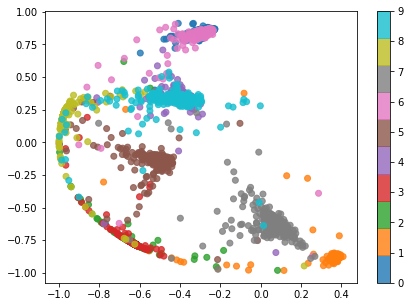

In [ ]:
outputs = []
ys = []

for x0, y in dl['test']:
      x0 = x0.cuda()
      output = model(x0).cpu().detach()
      output = F.normalize(output, p=2.0, dim=1, eps=1e-12)
      outputs.append(output)
      ys.append(y)

ys = torch.cat(ys)
outputs = torch.cat(outputs) 
fig = plt.figure(figsize = (7,5))
d = plt.scatter(outputs.numpy()[:,0],outputs.numpy()[:,1], c = ys.numpy(),
                cmap = 'tab10', alpha = 0.8)
fig.colorbar(d)

**Q5** Avec la fonction *sim_matrix*, visualiser la matrice des distances entre les sorties test. Quelle justesse peut-on obtenir, au mieux, sur la tâche de classification binaire ?

In [ ]:
def sim_matrix(a, b, eps=1e-8):
    """
    1) normalisation 
    2) produit X * tX
    eps pour la stab. numérique
    """
    a_n, b_n = a.norm(dim=1)[:, None], b.norm(dim=1)[:, None]
    a_norm = a / torch.max(a_n, eps * torch.ones_like(a_n))
    b_norm = b / torch.max(b_n, eps * torch.ones_like(b_n))
    #torch.mm : multiplication de matrices
    sim_mt = torch.mm(a_norm, b_norm.transpose(0, 1))
    return sim_mt

In [ ]:
from matplotlib.pyplot import imshow

# Matrice des distances :
dist = 1 - sim_matrix(outputs, outputs)

plt.figure(2)
t = 0.1
imshow(dist, vmin=0., vmax=1., cmap='hot')
plt.colorbar()

In [ ]:
# Calcul d'une justesse pour différentes valeurs seuils:
cs = ds['test'].class_size

for t in np.arange(0.01, 0.2, 0.01):
  #TAt : true accept et TRt: true reject
  TAts = []
  TRts = []

  for k in range(0,10):
    
    ...
  


**exercice n°2** 

Sur des jeux de données plus complexes que MNIST, une idée simple a permis d'améliorer sensiblement la séparation dans l'espace "**espace latent**".
L'idée consiste à prélever non des paires d'images, mais des [triplets](https://arxiv.org/pdf/1503.03832.pdf); dans ces triplets, on s'arrange pour que deux images contiennent le même objet (image "ancre" et image "positive") tandis que la troisième contient un objet différent (image "négative").
Dans la version la plus simple, on applique la constrative loss aux paires (ancre, positive), (ancre, négative) simultanément.

C'est cette version qui est illustrée ici.

**Q1** Compléter la classe DS_triplet de manière à pouvoir générer un triplet (ancre, positive, négative). Visualiser.

In [ ]:
class DS_triplet(torch.utils.data.Dataset):
    
    def __init__(self, X, tr = None):
        self.X = X                    
        self.nb_of_images = X.shape[0] 
        self.class_size = self.nb_of_images // 10
        self.transform = tr
            
    def __getitem__(self, idx):
        idx_classes = multinomial(torch.ones(10), 2)
        y = randint(0,2,(1,))
        idx_anchor = idx_classes[0] * self.class_size \
                + randint(0, self.class_size, (1,))
        idx_positive = idx_classes[0] * self.class_size \
                + randint(0, self.class_size, (1,))
        idx_negative = idx_classes[1] * self.class_size \
                + randint(0, self.class_size, (1,))     

        anchor = self.X[idx_anchor,...]
        positive = self.X[idx_positive,...]
        negative = self.X[idx_negative,...]

        if self.transform:
            anchor = self.transform(anchor)
            positive = self.transform(positive)
            negative = self.transform(negative)

        return anchor, positive, negative

    def __len__(self):
        return self.nb_of_images      


In [ ]:
ds = {phase : DS_triplet(X[phase], tr[phase]) \
              for phase in ['train','val']}

ds['test'] = DS_singleton(X['test'])

bs = 64

dl = {phase : DataLoader(ds[phase], shuffle = True, batch_size=bs, num_workers=2)\
              for phase in ['train', 'val']}

dl['test'] = DataLoader(ds['test'], shuffle = False, batch_size=bs, num_workers=2)

In [ ]:
x0, x1, x2  = next(iter(dl['val']))

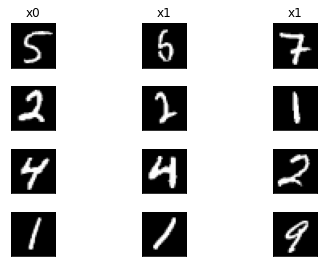

In [ ]:
import matplotlib.pyplot as plt

fig = plt.figure()
plt.plot()
for i in range(4):
  plt.subplot(4, 3, 1+3*i)
  if i==0:
    plt.title("x0")
  plt.tight_layout()
  plt.imshow(x0[i,0,:,:], cmap='gray')
  plt.xticks([])
  plt.yticks([])

  plt.subplot(4, 3, 2+3*i)
  if i==0:
    plt.title("x1")
  plt.tight_layout()
  plt.imshow(x1[i,0,:,:], cmap='gray')
  plt.xticks([])
  plt.yticks([])

  plt.subplot(4, 3, 3+3*i)
  if i==0:
    plt.title("x1")
  plt.tight_layout()
  plt.imshow(x2[i,0,:,:], cmap='gray')
  plt.xticks([])
  plt.yticks([])

In [ ]:
**Q2** Compléter la définition de la triplet loss:

In [ ]:
class TripletLoss(nn.Module):
    def __init__(self, margin=1.):
        super(TripletLoss, self).__init__()
        self.margin = margin
        
    
    def forward(self, anchor, positive, negative):
        cosap = cos(anchor, positive)
        cosan = cos(anchor, negative)
        losses = ...

        return losses.mean()

loss_fn = TripletLoss(0.2)

**Q3** Entraîner le même modèle que dans l'exercice n°2 et comparer les performances.

Extensions:
- triplet mining
- approches [self-supervisées](https://arxiv.org/pdf/2002.05709.pdf)
- [ré-identification](https://arxiv.org/pdf/2001.04193.pdf)